In [133]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

N_EXAMPLES   = 20_000    # number of simulated data sets
N_PER_SAMPLE = 100       # points (x_i, y_i) per data set
SIGMA_EPS    = 0.5       # noise scale (known here)
THETA_RANGE  = (0.0, 10) # prior range for θ during training
BATCH_SIZE   = 256
EPOCHS       = 50


Generate the summary statistics data set to learn from, have a dataset of summary statistic theta pairs

In [134]:
def make_summary_sx_sy(x, y):
    """Return [S_xx, S_xy, n] for one data set."""
    S_xx = tf.reduce_sum(tf.square(x), axis=-1, keepdims=True)   # shape (batch, 1)
    S_xy = tf.reduce_sum(x * y,        axis=-1, keepdims=True)   # shape (batch, 1)

    # Broadcast n so it has shape (batch, 1) as well
    n_val = tf.cast(tf.shape(x)[-1], tf.float32)                 # scalar
    n     = tf.fill(tf.shape(S_xx), n_val)                       # shape (batch, 1)

    return tf.concat([S_xx, S_xy, n], axis=-1)                   # shape (batch, 3)

def make_summary_covar(x, y):
    # x, y shape: (batch, n)
    mean_x = tf.reduce_mean(x, axis=-1, keepdims=True)
    mean_y = tf.reduce_mean(y, axis=-1, keepdims=True)
    x_cent = x - mean_x
    y_cent = y - mean_y

    var_x = tf.reduce_mean(x_cent**2, axis=-1, keepdims=True)
    var_y = tf.reduce_mean(y_cent**2, axis=-1, keepdims=True)
    cov_xy = tf.reduce_mean(x_cent * y_cent, axis=-1, keepdims=True)

    # concatenate into a vector of length 5: [mean_x, mean_y, var_x, cov_xy, var_y]
    return tf.concat([mean_x, mean_y, var_x, cov_xy, var_y], axis=-1)

def simulate_batch(batch_size, method="sxsy"):
    """Generate a batch of independent data sets & their θ.

    Default is to use the "sxsy" summary statistics the other option is "covar" """

    theta = tf.random.uniform([batch_size, 1], *THETA_RANGE)
    x     = tf.random.uniform([batch_size, N_PER_SAMPLE])
    noise = SIGMA_EPS * tf.random.normal([batch_size, N_PER_SAMPLE])
    y     = theta * x + noise

    if method == "sxsy":
        summary = make_summary_sx_sy(x, y)     # shape (batch, 3)
    elif method == "covar":
        summary = make_summary_covar(x, y)     # shape (batch, 5)
    else:
        raise ValueError("method must be covar or sxsy")

    return summary, theta

def make_dataset(n_examples, method="sxsy"):
    """tf.data.Dataset emitting (summary, θ) pairs. Allows for efficient processing"""
    steps = n_examples // BATCH_SIZE
    ds = tf.data.Dataset.range(steps).map(
        lambda _: simulate_batch(BATCH_SIZE, method=method),
        num_parallel_calls=tf.data.AUTOTUNE
    ).unbatch()
    return ds.prefetch(tf.data.AUTOTUNE)

def plot_loss(history, title="Loss curve"):
    """
    Plot training & validation loss stored in a Keras History object.
    Generates two stacked panels:
      • top: linear y-axis
      • bottom: semilog-y (base-10) axis
    """
    epochs = range(1, len(history.history["loss"]) + 1)

    fig, (ax_lin, ax_log) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)

    # linear plot
    ax_lin.plot(epochs, history.history["loss"],     label="train")
    ax_lin.plot(epochs, history.history["val_loss"], label="val")
    ax_lin.set_ylabel("MSE")
    ax_lin.set_title(title + " (linear scale)")
    ax_lin.legend()
    ax_lin.grid(True, which="both", linestyle="--", linewidth=0.5)

    # semilog-y plot
    ax_log.semilogy(epochs, history.history["loss"],     label="train")
    ax_log.semilogy(epochs, history.history["val_loss"], label="val")
    ax_log.set_xlabel("Epoch")
    ax_log.set_ylabel("MSE (log scale)")
    ax_log.set_title(title + " (semilogy)")
    ax_log.legend()
    ax_log.grid(True, which="both", linestyle="--", linewidth=0.5)

    plt.tight_layout()
    plt.show()

# Our dataset
train_ds = make_dataset(int(N_EXAMPLES*0.9))
val_ds   = make_dataset(int(N_EXAMPLES*0.1))


Define our basic model, 2 dense layers with relu, 32 width

In [135]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(3,)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)               # θ̂
])
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_78 (Dense)                │ (None, 32)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,217 (4.75 KB)

 Trainable params: 1,217 (4.75 KB)

 Non-trainable params: 0 (0.00 B)

Initialise and train our model - also plot the training loss

Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step - loss: 450.7928 - val_loss: 1.8305
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step - loss: 1.3322 - val_loss: 0.7419
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step - loss: 0.6941 - val_loss: 0.5331
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step - loss: 0.4937 - val_loss: 0.3886
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step - loss: 0.3821 - val_loss: 0.3006
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step - loss: 0.2779 - val_loss: 0.2274
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step - loss: 0.2081 - val_loss: 0.1456
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step - loss: 0.1331 - val_loss: 0.1009
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step - loss: 0.0859 - val_loss: 0.0594
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step - loss: 0.0513 - val_loss: 0.0430
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step - loss: 0.0405 - val_loss: 0.0361
Epoch 12/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/st

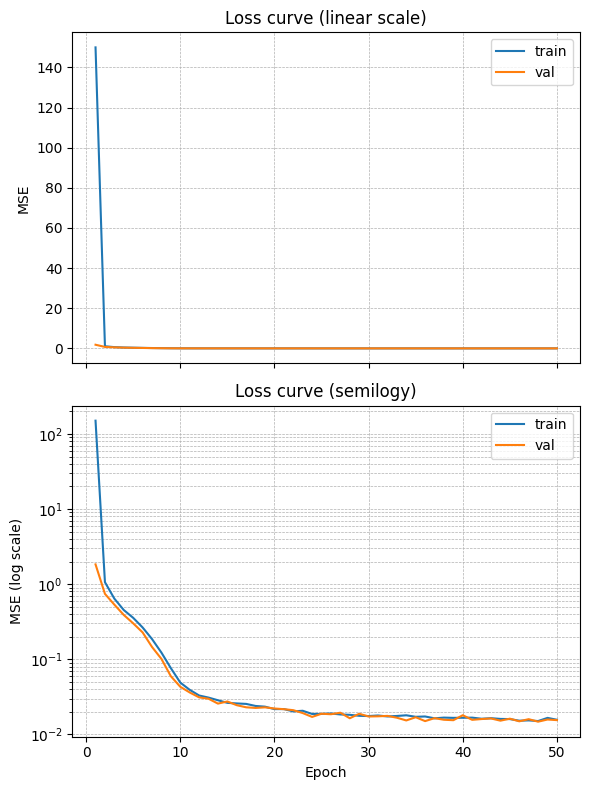

In [136]:
# Define our model
history = model.fit(train_ds.batch(BATCH_SIZE),
                    validation_data=val_ds.batch(BATCH_SIZE),
                    epochs=EPOCHS)

plot_loss(history)


Test to see how well performs on 1 data set.

In [137]:
# Simulate one brand-new data set
x_test  = np.random.rand(N_PER_SAMPLE).astype(np.float32)
theta_true = 5.0
y_test  = theta_true * x_test + SIGMA_EPS*np.random.randn(N_PER_SAMPLE).astype(np.float32)
summary_test = make_summary_sx_sy(x_test[None, :], y_test[None, :])  # shape (1,3)

theta_pred  = model.predict(summary_test)[0,0]
print(f"True θ = {theta_true:.2f},  Predicted θ = {theta_pred:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
True θ = 5.00,  Predicted θ = 5.03


Simulate a couple and find relative error

In [138]:
def average_relative_error(model, num_tests=10000, method="sxsy"):
    """
    Simulate `num_tests` new (x, y) samples, predict θ with the trained model,
    and return the mean relative error over the batch.
    """
    # Simulate a batch
    summaries, theta_true = simulate_batch(num_tests, method=method)        # (num_tests, 3) and (num_tests, 1)

    # Model prediction → shape (num_tests, 1)
    theta_pred = model.predict(summaries, verbose=0)

    # Relative error: |pred - true| / true   (add tiny eps to avoid div-by-0)
    eps       = 1e-8
    rel_error = np.abs(theta_pred.squeeze() - theta_true.numpy().squeeze()) / (theta_true.numpy().squeeze() + eps)

    # Return the mean error
    return rel_error.mean()

avg_re = average_relative_error(model, num_tests=1_000_000, method="sxsy")
print(f"Average relative error over 10000 tests: {avg_re:.4f}")


Average relative error over 10000 tests: 0.0818


### Using the other summary statistics

We first need to regenerate the new dataset and then will proceed as before instantiating a new model.

In [139]:
train_ds_covar = make_dataset(int(N_EXAMPLES*0.9),method="covar")
val_ds_covar   = make_dataset(int(N_EXAMPLES*0.1), method="covar")

In [140]:
model_covar = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(5,)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)               # θ̂
])
model_covar.compile(optimizer='adam', loss='mse')
model_covar.summary()

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_81 (Dense)                │ (None, 32)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,281 (5.00 KB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 0 (0.00 B)

Fit the model with the new dataset

Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - loss: 19.5839 - val_loss: 0.3722
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step - loss: 0.3144 - val_loss: 0.1201
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step - loss: 0.1070 - val_loss: 0.0748
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step - loss: 0.0741 - val_loss: 0.0709
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step - loss: 0.0674 - val_loss: 0.0626
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step - loss: 0.0716 - val_loss: 0.0655
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step - loss: 0.0661 - val_loss: 0.0669
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step - loss: 0.0665 - val_loss: 0.0589
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step - loss: 0.0641 - val_loss: 0.0649
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step - loss: 0.0611 - val_loss: 0.0632
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step - loss: 0.0633 - val_loss: 0.0596
Epoch 12/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/ste

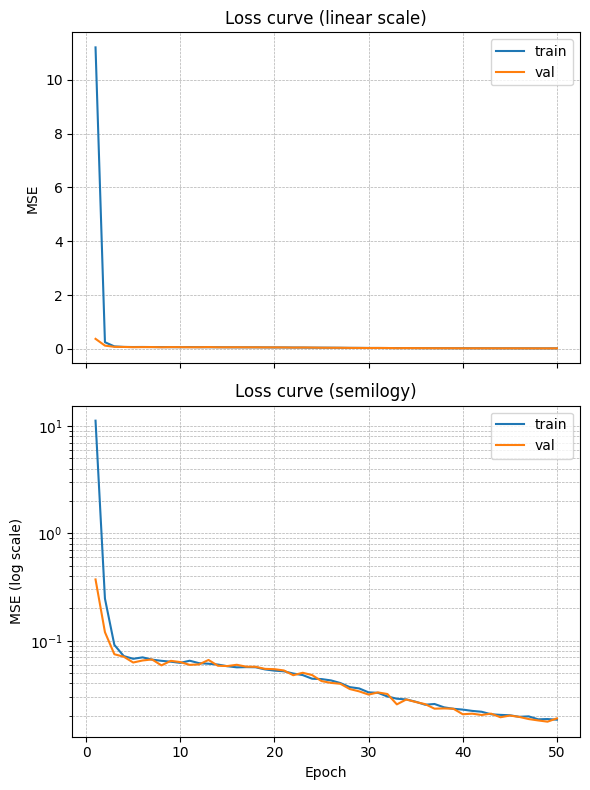

In [141]:
# fit our model
history_covar = model_covar.fit(train_ds_covar.batch(BATCH_SIZE),
                    validation_data=val_ds_covar.batch(BATCH_SIZE),
                    epochs=EPOCHS)

plot_loss(history_covar)


Test to see how well performs on the same dataset as before

In [142]:
# Simulate one brand-new data set
x_test  = np.random.rand(N_PER_SAMPLE).astype(np.float32)
theta_true = 5.0
y_test  = theta_true * x_test + SIGMA_EPS*np.random.randn(N_PER_SAMPLE).astype(np.float32)
summary_test_covar = make_summary_covar(x_test[None, :], y_test[None, :])  # shape (1,5)

theta_pred  = model_covar.predict(summary_test_covar)[0,0]
print(f"True θ = {theta_true:.2f},  Predicted θ = {theta_pred:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
True θ = 5.00,  Predicted θ = 5.12


Now test the average loss on a (different) dataset but as before

In [143]:
avg_re_covar = average_relative_error(model_covar, num_tests=1_000_000, method="covar")
print(f"Average relative error over 1 000 000 tests: {avg_re_covar:.4f}")

Average relative error over 1 000 000 tests: 0.2122


### Results

We see that after 1 million tests for both the error is fairly similar for both. Perhaps slightly better for sxsy method. Both training loss curves look pretty similar

### Multi-dimensional case

In [165]:
D = 5                  #  number of parameters θ_j

def simulate_batch_multi_dim(batch_size, method="sufficient"):
    """
    Return  (summary_stats , true_theta)  for a batch of size `batch_size`.
    """
    # Generate our "true" theta and then use that to generate our X data matrix
    theta = tf.random.uniform([batch_size, D, 1], *THETA_RANGE)          # (B, D, 1)
    X     = tf.random.uniform([batch_size, N_PER_SAMPLE, D])             # (B, n, D)

    # Generate noise and then create output variable
    noise = SIGMA_EPS * tf.random.normal([batch_size, N_PER_SAMPLE, 1])  # (B, n, 1)
    y     = tf.matmul(X, theta) + noise                                  # (B, n, 1)

    # Generate our summary statistics based on the specified method
    if method == "sufficient":             #   S_xx  and  S_xy
        S_xx = tf.matmul(X, X, transpose_a=True)          # (B, D, D)
        S_xy = tf.matmul(X, y, transpose_a=True)          # (B, D, 1)
        summary = tf.concat(
            [tf.reshape(S_xx, [batch_size, D*D]),
             tf.reshape(S_xy, [batch_size, D])], axis=-1) # (B, D² + D)

    elif method == "mean_covar":           #   mean + covariance
        mean_x = tf.reduce_mean(X, axis=1)                 # (B, D)
        mean_y = tf.reduce_mean(y, axis=1)                 # (B, 1)

        xc = X - tf.expand_dims(mean_x, 1)                 # centre X
        yc = y - tf.expand_dims(mean_y, 1)                 # centre y

        cov_x  = tf.matmul(xc, xc, transpose_a=True) / N_PER_SAMPLE        # (B, D, D)
        cov_xy = tf.matmul(xc, yc, transpose_a=True) / N_PER_SAMPLE        # (B, D, 1)

        summary = tf.concat(
            [mean_x,                     # D
             mean_y,                     # responsible for the y intercept
             tf.reshape(cov_x,  [ -1, D*D]),
             tf.reshape(cov_xy, [ -1, D])],
            axis=-1
        )                                                   # (B, D*D + 2D + 1)

    else:
        raise ValueError("Unknown method")

    theta = tf.squeeze(theta, axis=-1)      # (B, D)  → easier for Keras
    return summary, theta

def make_dataset_multi_dim(n_examples, method="sufficient"):
    """tf.data.Dataset emitting (summary, θ) pairs. Allows for efficient processing"""
    steps = n_examples // BATCH_SIZE
    ds = tf.data.Dataset.range(steps).map(
        lambda _: simulate_batch_multi_dim(BATCH_SIZE, method=method),
        num_parallel_calls=tf.data.AUTOTUNE
    ).unbatch()
    return ds.prefetch(tf.data.AUTOTUNE)


Create our 2 databases using a slightly modified version from before.

In [166]:
train_ds_sufficient = make_dataset_multi_dim(int(N_EXAMPLES*0.9), method="sufficient")
val_ds_sufficient   = make_dataset_multi_dim(int(N_EXAMPLES*0.1), method="sufficient")

train_ds_mean_covar = make_dataset_multi_dim(int(N_EXAMPLES*0.9), method="mean_covar")
val_ds_mean_covar   = make_dataset_multi_dim(int(N_EXAMPLES*0.1), method="mean_covar")


Define our model. Will use a similar architecture for both just changing the input size

In [167]:
# Sufficient
INPUT_SIZE = D*D + D

model_sufficient = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(INPUT_SIZE,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(D)                 # θ̂₁ … θ̂_D
])

model_sufficient.compile(optimizer='adam', loss='mse')
model_sufficient.summary()

Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_96 (Dense)                │ (None, 64)             │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_97 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_98 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,469 (25.27 KB)

 Trainable params: 6,469 (25.27 KB)

 Non-trainable params: 0 (0.00 B)

In [168]:
# Mean CoVar

INPUT_SIZE = D*D + 2*D + 1

model_mean_covar = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(INPUT_SIZE,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(D)                 # θ̂₁ … θ̂_D
])

model_mean_covar.compile(optimizer='adam', loss='mse')
model_mean_covar.summary()

Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_99 (Dense)                │ (None, 64)             │         2,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_100 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,853 (26.77 KB)

 Trainable params: 6,853 (26.77 KB)

 Non-trainable params: 0 (0.00 B)

Now we fit the 2 models and plot the training loss curve

Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10248.2920 - val_loss: 72.9508
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step - loss: 66.7140 - val_loss: 47.0571
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 42.1732 - val_loss: 27.0360
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step - loss: 23.7836 - val_loss: 15.5329
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step - loss: 14.0348 - val_loss: 10.4839
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - loss: 9.3768 - val_loss: 7.7652
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - loss: 7.3896 - val_loss: 6.8078
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - loss: 6.4837 - val_loss: 6.2038
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - loss: 5.8472 - val_loss: 5.2159
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - loss: 5.1368 - val_loss: 5.0389
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step - loss: 4.8546 - val_loss: 4.7873
Epoch 12/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 9

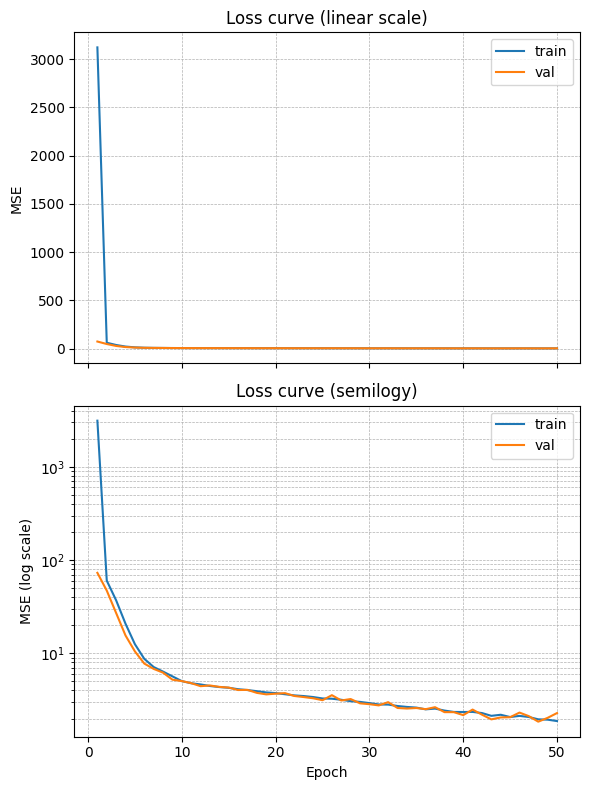

In [169]:
# Sufficient
history_sufficient = model_sufficient.fit(train_ds_sufficient.batch(BATCH_SIZE),
                    validation_data=val_ds_sufficient.batch(BATCH_SIZE),
                    epochs=EPOCHS)

plot_loss(history_sufficient)

Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 20.4452 - val_loss: 6.4671
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step - loss: 6.3886 - val_loss: 6.1463
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - loss: 5.9248 - val_loss: 5.2174
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step - loss: 4.8085 - val_loss: 3.6390
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - loss: 3.2078 - val_loss: 2.0623
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step - loss: 1.8308 - val_loss: 1.1519
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step - loss: 1.0236 - val_loss: 0.7797
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step - loss: 0.7716 - val_loss: 0.7056
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - loss: 0.7016 - val_loss: 0.6622
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step - loss: 0.6548 - val_loss: 0.6301
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step - loss: 0.6242 - val_loss: 0.6103
Epoch 12/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step 

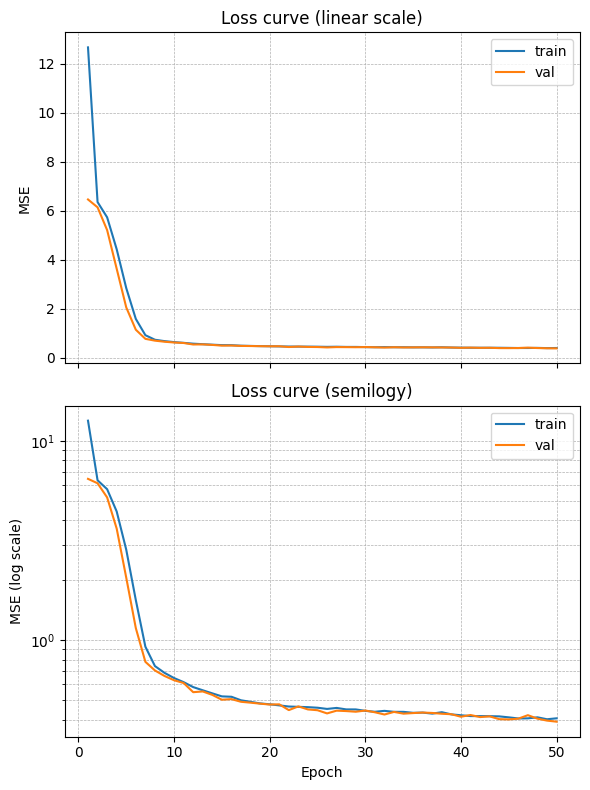

In [170]:
# Mean CoVar

history_mean_covar = model_mean_covar.fit(train_ds_mean_covar.batch(BATCH_SIZE),
                    validation_data=val_ds_mean_covar.batch(BATCH_SIZE),
                    epochs=EPOCHS)

plot_loss(history_mean_covar)

### Results

We can see here that we are able to get good training errors for both here, over 50 epochs next we will compare on the test set

In [171]:
def average_relative_error_multi_dim(model, num_tests=10000, method="sufficient"):
    """
    Simulate `num_tests` new (x, y) samples, predict θ with the trained model,
    and return the mean relative error over the batch.

    Similar to the 1d function
    """
    # Simulate a batch
    summaries, theta_true = simulate_batch_multi_dim(num_tests, method=method)        # (num_tests, 3) and (num_tests, 1)

    # Model prediction → shape (num_tests, 1)
    theta_pred = model.predict(summaries, verbose=0)

    eps        = 1e-8 # Again add on as before
    diff       = theta_pred - theta_true.numpy()        # (num_tests, D)
    numer      = np.linalg.norm(diff,        axis=1)    # L2 norm of errors
    denom      = np.linalg.norm(theta_true.numpy(), axis=1) + eps
    rel_error  = numer / denom

    return rel_error.mean()

In [173]:
num_tests = 10000

avg_re_sufficient = average_relative_error_multi_dim(model_sufficient, num_tests=num_tests, method="sufficient")
print(f"Average relative error over {num_tests} tests for sufficient: {avg_re_sufficient:.4f}")

avg_re_mean_covar = average_relative_error_multi_dim(model_mean_covar, num_tests=num_tests, method="mean_covar")
print(f"Average relative error over {num_tests} tests for sufficient: {avg_re_mean_covar:.4f}")

Average relative error over 10000 tests for sufficient: 0.2636
Average relative error over 10000 tests for sufficient: 0.1072


We see that for larger theta the variance method is performing better. This is because the 2 essentially encode the same information but the covariance is in a better scaled coordinate system.